## 实验5，环境承载量改到65，调整learning_rate

### 环境及智能体

- 环境： MinorityGame_1， 少数派游戏，101人博弈，无穷博弈，创建环境时可自定义环境承载量，本实验中固定为65
- 智能体：QLearningAgent，创建智能体时支持自定义学习率、折扣因子以及探索系数，本实验中固定折扣因子和探索系数，观察不同学习率对玩家决策及收益的影响

### 实验结果

101人少数博弈，固定环境承载量为65，探索系数为0.1，折扣因子为0.1时，选取不同的学习率,观察玩家决策和平均收益,发现:

1. 相较于0.1和0.05，选用0.3及以上的学习率，玩家决策波动大
2. 相较于0.1和0.05，选用0.3及以上的学习率，玩家平均收益降低，但是学习率越高玩家的收益波动越小
3. 探索因子为0.1时，玩家并不能很好的学习到环境承载量这一信息，无论怎么调整学习率，平均每轮总收益都在50之下

分析与环境承载量50时的差异：

- 当环境承载量为50时，玩家决策在50左右波动，无论选择1的人数在50以上还是50以下，选择1的人数与50的差距就是回合总收益与最优回合总收益的差距
- 环境承载量变为65时，玩家决策在65左右波动，如果最终选择1的人数小于65，则得到一个接近最优收益的结果，否则会得到一个较差的结果(当回合总收益在35以下）

根据实验4可知较高的折扣因子可以提高环境承载量为65时玩家的回合总收益，下面做101人少数博弈，固定环境承载量为65，探索系数为0.1，折扣因子为0.9时，选取不同的学习率,观察玩家决策和平均收益,发现:

1. 在尝试的四种不同学习率下，增大折扣因子均可提高回合总收益
2. 折扣因子固定为0.9时，学习率越小，总收益达到稳定时的收益约接近最优收益
3. 折扣因子固定为0.9时，学习率越小，总收益达到稳定状态所需时间越长


### 实验内容

#### 实验准备

In [75]:
# MG环境
import gym
from gym import spaces
from gym.utils import seeding
import random
import numpy as np
import copy
import math, random
from collections import deque
import matplotlib.pyplot as plt
import numpy as np

# %matplotlib inline

class MinorityGame_1(gym.Env):
    '''
    Minority Game, we have some agent, every agent can choose 1 or 0 every day.
    In midnight, all of the day to make a few choices of the agent to get +1 reward.
    '''

    def __init__(self, env_max=50):
        '''
        环境初始化:
        玩家数固定101;
        env_max 环境承载量，选择1能获取收益的最大人数，默认为50;
        action_space 动作空间，大小为2，玩家只能选择0或1;
        observation_space 观测空间，这个环境使用2，玩家立足于上一次博弈的状态;
        '''
        self.env_max = env_max
        self.action_space = spaces.Discrete(2)
        self.observation_space = spaces.Discrete(2)
        self.seed()


    def seed(self, seed=None):
        '''
        设置seed
        '''
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def step(self, action_101):
        '''
        每一步博弈：
        1. 检查输入是否合法
        2. 统计选择1的人数allpick，allpick不超过env_max则1获胜，否则0获胜
        3. 返回S(玩家本回合动作), R(所有玩家的奖励列表), done(False，无尽博弈)
        '''
        assert len(action_101) == 101
        assert all(map(lambda x:self.action_space.contains(x), action_101))
        allpick = sum(action_101)
        reward_101 = []
        for action in action_101:
            if action == 1 and allpick <= self.env_max or action == 0 and allpick > self.env_max:
                reward_101.append(1)
            else:
                reward_101.append(0)

        done = True

        return action_101, reward_101, done, {}

    def reset(self):
        '''
        重置环境，每轮第一次博弈给所有玩家一个随机状态
        '''
        # return [0]*101
        return [random.randint(0,1) for _ in range(101)]

# Qlearning智能体
class QLearningAgent:
    '''
    Q-learning智能体实现
    '''

    def __init__(self, env, gamma=0.9, learning_rate=0.1, epsilon=0.1):
        '''
        Q-learning智能体初始化:
        env 智能体的博弈环境；
        gamma 折扣因子，n步后的奖励为 pow(gamma, n)*Rn, gamma越大表示越重视长期收益。
        learning_rata 学习率，Qlearning 更新过程为:Q(s,a) += learning_rate * (R + gamma * Qmax - Q(s,a)),
                      学习率越大表示越不依赖过去学习的结果
        '''
        self.gamma = gamma
        self.learning_rate = learning_rate
        self.epsilon = epsilon
        self.action_n = env.action_space.n
        self.q = np.zeros((env.observation_space.n, env.action_space.n))
        

    def decide(self, state):
        '''
        epsilon-greedy策略，另外Q表所有值相等表示智能体还没有学到任何经验，这时也鼓励探索。
        '''
        if np.random.uniform() > self.epsilon and self.q[state].argmax() != self.q[state].argmin():
            action = self.q[state].argmax()
        else:
            action = 0 if np.random.randint(self.action_n) < 0.5 else 1
        return action
    
    def learn(self, state, action, reward, next_state, done):
        '''
        Q(s,a) += learning_rate * (R + gamma * Qmax - Q(s,a)
        '''
        u = reward + self.gamma * self.q[next_state].max()
        td_error = u - self.q[state, action]
        self.q[state, action] += self.learning_rate * td_error

def play_qlearning(env, agent_101, episodes,render=False):
    '''
    Qlearning智能体一次游戏
    参数:
    env: 游戏环境
    agent_101：101个智能体列表
    episodes: 最大轮数
    render：是否图形显示
    返回值：
    episode_reward
    '''
    episode_rewards = []
    episode_actions = []
    # 初始化S
    observation_101 = env.reset()
    for _ in range(episodes):
        # 各智能体根据环境选择动作
        action_101 = [agent.decide(observation) for agent, observation in zip(agent_101, observation_101)]
        # 执行动作后得到环境奖励和新状态
        next_observation_101, reward_101, done, _ = env.step(action_101)
        # 为所有智能体更新Q表
        for agent, observation, action, reward, next_observation in zip(agent_101, observation_101, action_101, reward_101, next_observation_101):
            agent.learn(observation, action, reward, next_observation,done)
        # 更新状态
        observation = next_observation
        # 上面是Q-learning完整的一步，下面是数据统计
        # 统计动作
        episode_actions.append(action_101)
        # 统计奖励
        episode_rewards.append(reward_101)
    return episode_rewards, episode_actions

def moving_average(lst, N):
    '''
    计算移动平均
    参数:
    lst: 输入列表
    N: 窗口大小
    返回值:
    res: 移动平均列表
    '''
    res = []
    for i in range(len(lst)):
        l = max(i-N+1, 0)
        r = i+1
        res.append(sum(lst[l:r])/(r-l))
    return res

def density(lst):
    '''
    将玩家决策原始数据转换成密度数据
    参数:
    lst: 玩家决策原始数据
    返回值:
    res: 玩家决策密度数据
    例:
    输入: [1,1,2,3]
    输出: [0,2,1,1] + [0]*98
    '''
    from collections import Counter
    res = [0] * 102
    tbl = Counter(lst)
    for i in tbl:
        res[i] = tbl[i]/len(lst)
    return res

def variance(lst, N):
    '''
    序列转为方差序列
    参数:
    lst: 输入序列
    N: 计算方差所需元素数
    返回值:
    res: 方差序列
    '''
    import numpy as np
    res = []
    for i in range(len(lst)):
        l = max(i-N+1, 0)
        r = i+1
        res.append(np.var(lst[l:r]) if l else 0)
    return res

### 实验过程

1. 基础测试：gamma = 0.1, learning_rate=0.1, epislon=0,1, 博弈3000次，观察玩家收益和动作

玩家总收益


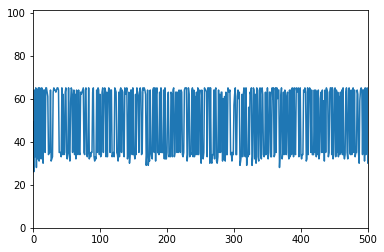

选择1的人数


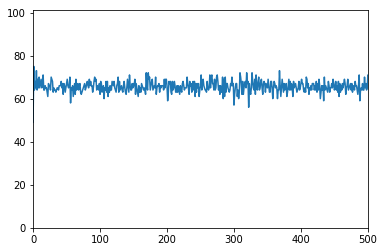

玩家总收益10轮移动平均


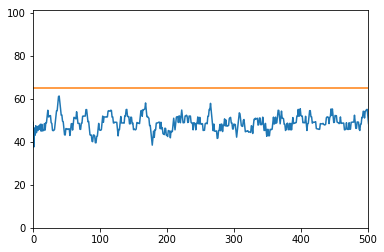

In [2]:
# 创建环境
env = MinorityGame_1(65)
# 创建玩家
agent_101 = [QLearningAgent(env,gamma=0.1,learning_rate=0.1,epsilon=0.1) for _ in range(101)]

rewards_0, actions_0 = play_qlearning(env,agent_101,3000)

print("玩家总收益")
# 玩家总收益（仅绘制前500轮）
plt.clf()
plt.plot(moving_average([sum(reward) for reward in rewards_0],1))
plt.ylim(0,101)
plt.xlim(0,500)
plt.pause(0.1)
print("选择1的人数")
# 选择1的人数（仅绘制前500轮）
plt.clf()
plt.plot([sum(action) for action in actions_0])
plt.ylim(0,101)
plt.xlim(0,500)
plt.pause(0.1)
print("玩家总收益10轮移动平均")
# 玩家总收益10轮移动平均（仅绘制前500轮）
plt.clf()
plt.plot(moving_average([sum(reward) for reward in rewards_0],10))
plt.plot([65]*3000)
plt.ylim(0,101)
plt.xlim(0,500)
plt.pause(0.1)

2. 调整learning_rate，观测对结果的影响

玩家总收益


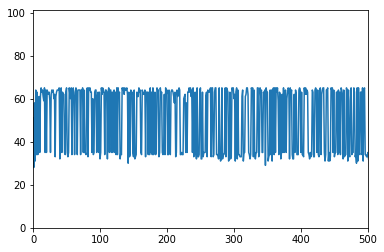

选择1的人数


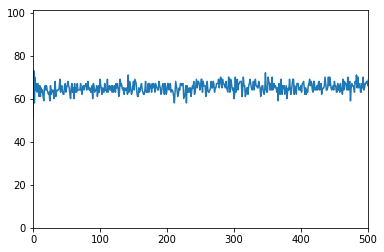

玩家总收益10轮移动平均


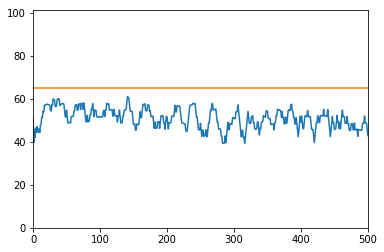

In [3]:
# 创建环境
env = MinorityGame_1(65)
# 创建玩家
agent_101 = [QLearningAgent(env,gamma=0.1,learning_rate=0.05,epsilon=0.1) for _ in range(101)]
# 博弈
rewards_1a, actions_1a = play_qlearning(env,agent_101,3000)
print("玩家总收益")
# 玩家总收益（仅绘制前500轮）
plt.clf()
plt.plot(moving_average([sum(reward) for reward in rewards_1a],1))
plt.ylim(0,101)
plt.xlim(0,500)
plt.pause(0.1)
print("选择1的人数")
# 选择1的人数（仅绘制前500轮）
plt.clf()
plt.plot([sum(action) for action in actions_1a])
plt.ylim(0,101)
plt.xlim(0,500)
plt.pause(0.1)
print("玩家总收益10轮移动平均")
# 玩家总收益10轮移动平均（仅绘制前500轮）
plt.clf()
plt.plot(moving_average([sum(reward) for reward in rewards_1a],10))
plt.plot([65]*3000)
plt.ylim(0,101)
plt.xlim(0,500)
plt.pause(0.1)

玩家总收益


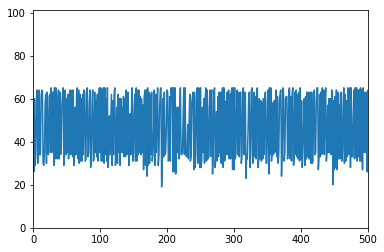

选择1的人数


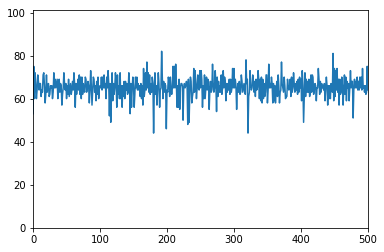

玩家总收益10轮移动平均


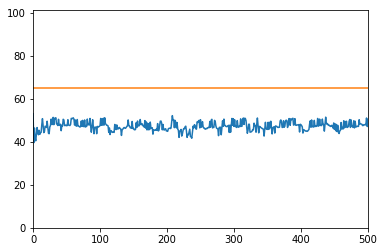

In [4]:
# 创建环境
env = MinorityGame_1(65)
# 创建玩家
agent_101 = [QLearningAgent(env,gamma=0.1,learning_rate=0.3,epsilon=0.1) for _ in range(101)]
# 博弈
rewards_1b, actions_1b = play_qlearning(env,agent_101,3000)
print("玩家总收益")
# 玩家总收益（仅绘制前500轮）
plt.clf()
plt.plot(moving_average([sum(reward) for reward in rewards_1b],1))
plt.ylim(0,101)
plt.xlim(0,500)
plt.pause(0.1)
print("选择1的人数")
# 选择1的人数（仅绘制前500轮）
plt.clf()
plt.plot([sum(action) for action in actions_1b])
plt.ylim(0,101)
plt.xlim(0,500)
plt.pause(0.1)
print("玩家总收益10轮移动平均")
# 玩家总收益10轮移动平均（仅绘制前500轮）
plt.clf()
plt.plot(moving_average([sum(reward) for reward in rewards_1b],10))
plt.plot([65]*3000)
plt.ylim(0,101)
plt.xlim(0,500)
plt.pause(0.1)

玩家总收益


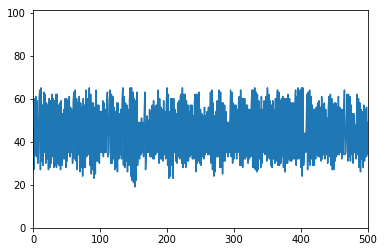

选择1的人数


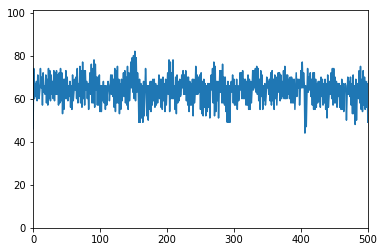

玩家总收益10轮移动平均


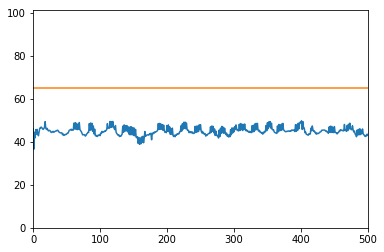

In [5]:
# 创建环境
env = MinorityGame_1(65)
# 创建玩家
agent_101 = [QLearningAgent(env,gamma=0.1,learning_rate=0.6,epsilon=0.1) for _ in range(101)]
# 博弈
rewards_1c, actions_1c = play_qlearning(env,agent_101,3000)
print("玩家总收益")
# 玩家总收益（仅绘制前500轮）
plt.clf()
plt.plot(moving_average([sum(reward) for reward in rewards_1c],1))
plt.ylim(0,101)
plt.xlim(0,500)
plt.pause(0.1)
print("选择1的人数")
# 选择1的人数（仅绘制前500轮）
plt.clf()
plt.plot([sum(action) for action in actions_1c])
plt.ylim(0,101)
plt.xlim(0,500)
plt.pause(0.1)
print("玩家总收益10轮移动平均")
# 玩家总收益10轮移动平均（仅绘制前500轮）
plt.clf()
plt.plot(moving_average([sum(reward) for reward in rewards_1c],10))
plt.plot([65]*3000)
plt.ylim(0,101)
plt.xlim(0,500)
plt.pause(0.1)

玩家总收益


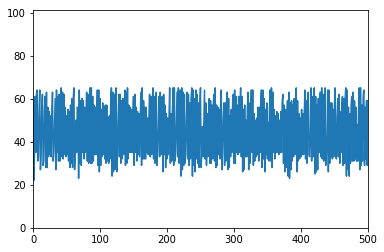

选择1的人数


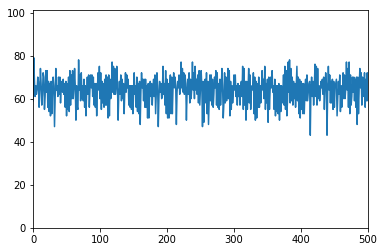

玩家总收益10轮移动平均


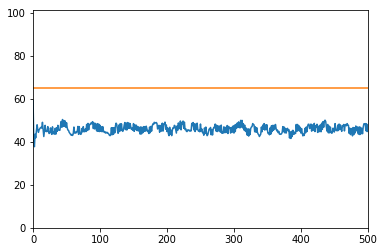

In [6]:
# 创建环境
env = MinorityGame_1(65)
# 创建玩家
agent_101 = [QLearningAgent(env,gamma=0.1,learning_rate=0.9,epsilon=0.1) for _ in range(101)]
# 博弈
rewards_1d, actions_1d = play_qlearning(env,agent_101,3000)
print("玩家总收益")
# 玩家总收益（仅绘制前500轮）
plt.clf()
plt.plot(moving_average([sum(reward) for reward in rewards_1d],1))
plt.ylim(0,101)
plt.xlim(0,500)
plt.pause(0.1)
print("选择1的人数")
# 选择1的人数（仅绘制前500轮）
plt.clf()
plt.plot([sum(action) for action in actions_1d])
plt.ylim(0,101)
plt.xlim(0,500)
plt.pause(0.1)
print("玩家总收益10轮移动平均")
# 玩家总收益10轮移动平均（仅绘制前500轮）
plt.clf()
plt.plot(moving_average([sum(reward) for reward in rewards_1d],10))
plt.plot([65]*3000)
plt.ylim(0,101)
plt.xlim(0,500)
plt.pause(0.1)

不同learning_rate对平均收益的影响


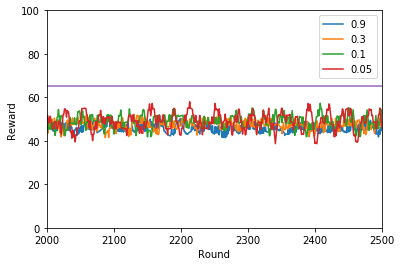

In [25]:
# 玩家总收益10轮移动平均，不同gamma对比
print("不同learning_rate对平均收益的影响")
plt.clf()
plt.xlabel("Round")
plt.ylabel("Reward")
plt.plot(moving_average([sum(reward) for reward in rewards_1d],10),label ='0.9')
# plt.plot(moving_average([sum(reward) for reward in rewards_1c],10),label ='0.6')
plt.plot(moving_average([sum(reward) for reward in rewards_1b],10),label ='0.3')
plt.plot(moving_average([sum(reward) for reward in rewards_0],10),label ='0.1')
plt.plot(moving_average([sum(reward) for reward in rewards_1a],10),label ='0.05')
plt.plot([65]*3000)
plt.ylim(0,100)
plt.xlim(2000,2500)
plt.legend()
plt.show()

不同gamma对玩家决策的影响


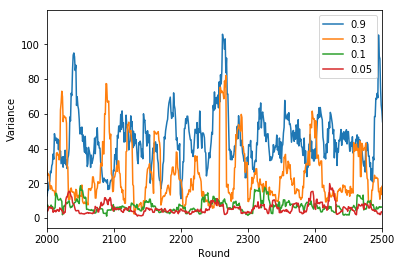

In [27]:
# 玩家决策，不同gamma对比
print("不同gamma对玩家决策的影响")
plt.clf()
plt.xlabel("Round")
plt.ylabel("Variance")
plt.plot(variance([sum(reward) for reward in actions_1d],10),label ='0.9')
# plt.plot(variance([sum(reward) for reward in actions_1c],10),label ='0.6')
plt.plot(variance([sum(reward) for reward in actions_1b],10),label ='0.3')
plt.plot(variance([sum(reward) for reward in actions_0],10),label ='0.1')
plt.plot(variance([sum(reward) for reward in actions_1a],10),label ='0.05')
plt.xlim(2000,2500)
# plt.axvline(51)
plt.legend()
plt.show()

不同learning_rate对玩家决策的影响


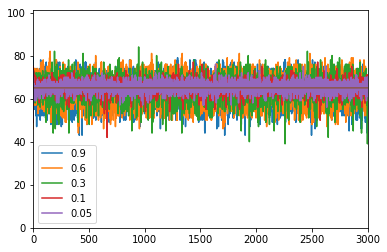

In [8]:
# 玩家决策，不同gamma对比
print("不同learning_rate对玩家决策的影响")
plt.clf()
plt.plot(moving_average([sum(reward) for reward in actions_1d],1),label ='0.9')
plt.plot(moving_average([sum(reward) for reward in actions_1c],1),label ='0.6')
plt.plot(moving_average([sum(reward) for reward in actions_1b],1),label ='0.3')
plt.plot(moving_average([sum(reward) for reward in actions_0],1),label ='0.1')
plt.plot(moving_average([sum(reward) for reward in actions_1a],1),label ='0.05')
plt.plot([65]*3000)
plt.ylim(0,101)
plt.xlim(0,3000)
plt.legend()
plt.show()

不同learning_rate对玩家决策的影响


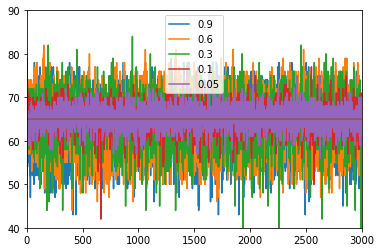

In [9]:
# 玩家总收益10轮移动平均，不同gamma对比
print("不同learning_rate对玩家决策的影响")
plt.clf()
plt.plot(moving_average([sum(reward) for reward in actions_1d],1),label ='0.9')
plt.plot(moving_average([sum(reward) for reward in actions_1c],1),label ='0.6')
plt.plot(moving_average([sum(reward) for reward in actions_1b],1),label ='0.3')
plt.plot(moving_average([sum(reward) for reward in actions_0],1),label ='0.1')
plt.plot(moving_average([sum(reward) for reward in actions_1a],1),label ='0.05')
plt.plot([65]*3000)
plt.ylim(40,90)
plt.xlim(0,3000)
plt.legend()
plt.show()

In [29]:
print("0.05",sum([sum(reward) for reward in rewards_1a[2000:2500]])/500)
print(" 0.1",sum([sum(reward) for reward in rewards_0[2000:2500]])/500)
print(" 0.3",sum([sum(reward) for reward in rewards_1b[2000:2500]])/500)
print(" 0.6",sum([sum(reward) for reward in rewards_1c[2000:2500]])/500)
print(" 0.9",sum([sum(reward) for reward in rewards_1d[2000:2500]])/500)

0.05 48.872
 0.1 49.04
 0.3 47.312
 0.6 45.048
 0.9 45.778


3. 修改折扣因子为0.9，调整learning_rate，观测对结果的影响

玩家总收益


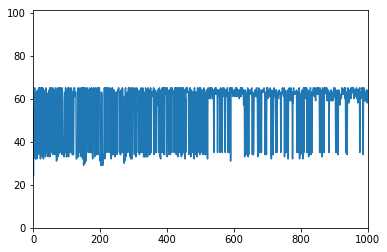

选择1的人数


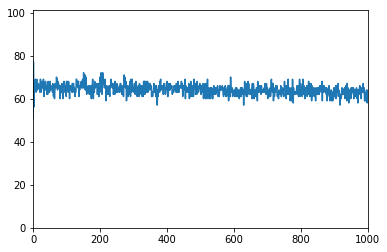

玩家总收益10轮移动平均


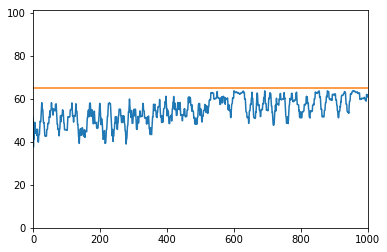

In [11]:
# 创建环境
env = MinorityGame_1(65)
# 创建玩家
agent_101 = [QLearningAgent(env,gamma=0.9,learning_rate=0.05,epsilon=0.1) for _ in range(101)]
# 博弈
rewards_2a, actions_2a = play_qlearning(env,agent_101,3000)
print("玩家总收益")
# 玩家总收益（仅绘制前1000轮）
plt.clf()
plt.plot(moving_average([sum(reward) for reward in rewards_2a],1))
plt.ylim(0,101)
plt.xlim(0,1000)
plt.pause(0.1)
print("选择1的人数")
# 选择1的人数（仅绘制前1000轮）
plt.clf()
plt.plot([sum(action) for action in actions_2a])
plt.ylim(0,101)
plt.xlim(0,1000)
plt.pause(0.1)
print("玩家总收益10轮移动平均")
# 玩家总收益10轮移动平均（仅绘制前1000轮）
plt.clf()
plt.plot(moving_average([sum(reward) for reward in rewards_2a],10))
plt.plot([65]*3000)
plt.ylim(0,101)
plt.xlim(0,1000)
plt.pause(0.1)

玩家总收益


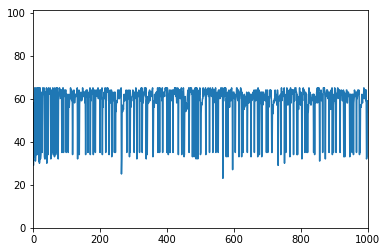

选择1的人数


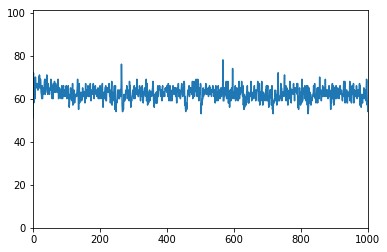

玩家总收益10轮移动平均


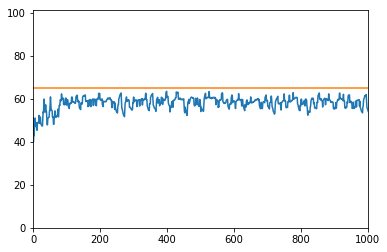

In [12]:
# 创建环境
env = MinorityGame_1(65)
# 创建玩家
agent_101 = [QLearningAgent(env,gamma=0.9,learning_rate=0.3,epsilon=0.1) for _ in range(101)]
# 博弈
rewards_2b, actions_2b = play_qlearning(env,agent_101,3000)
print("玩家总收益")
# 玩家总收益（仅绘制前1000轮）
plt.clf()
plt.plot(moving_average([sum(reward) for reward in rewards_2b],1))
plt.ylim(0,101)
plt.xlim(0,1000)
plt.pause(0.1)
print("选择1的人数")
# 选择1的人数（仅绘制前1000轮）
plt.clf()
plt.plot([sum(action) for action in actions_2b])
plt.ylim(0,101)
plt.xlim(0,1000)
plt.pause(0.1)
print("玩家总收益10轮移动平均")
# 玩家总收益10轮移动平均（仅绘制前1000轮）
plt.clf()
plt.plot(moving_average([sum(reward) for reward in rewards_2b],10))
plt.plot([65]*3000)
plt.ylim(0,101)
plt.xlim(0,1000)
plt.pause(0.1)

玩家总收益


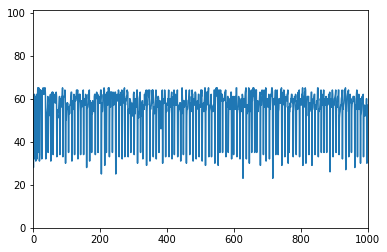

选择1的人数


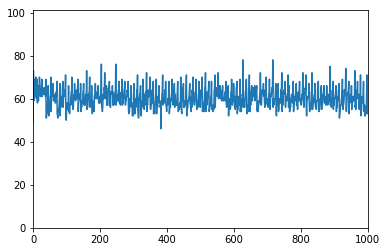

玩家总收益10轮移动平均


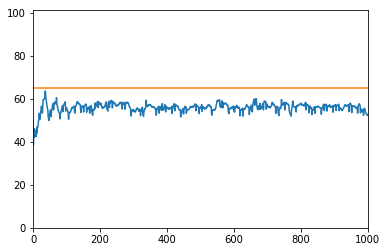

In [13]:
# 创建环境
env = MinorityGame_1(65)
# 创建玩家
agent_101 = [QLearningAgent(env,gamma=0.9,learning_rate=0.6,epsilon=0.1) for _ in range(101)]
# 博弈
rewards_2c, actions_2c = play_qlearning(env,agent_101,3000)
print("玩家总收益")
# 玩家总收益（仅绘制前1000轮）
plt.clf()
plt.plot(moving_average([sum(reward) for reward in rewards_2c],1))
plt.ylim(0,101)
plt.xlim(0,1000)
plt.pause(0.1)
print("选择1的人数")
# 选择1的人数（仅绘制前1000轮）
plt.clf()
plt.plot([sum(action) for action in actions_2c])
plt.ylim(0,101)
plt.xlim(0,1000)
plt.pause(0.1)
print("玩家总收益10轮移动平均")
# 玩家总收益10轮移动平均（仅绘制前1000轮）
plt.clf()
plt.plot(moving_average([sum(reward) for reward in rewards_2c],10))
plt.plot([65]*3000)
plt.ylim(0,101)
plt.xlim(0,1000)
plt.pause(0.1)

玩家总收益


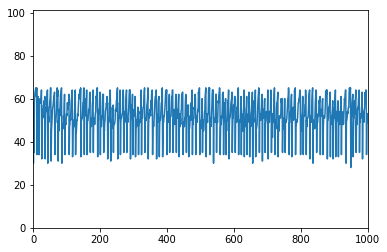

选择1的人数


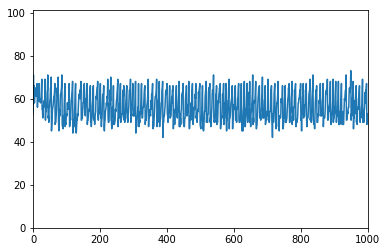

玩家总收益10轮移动平均


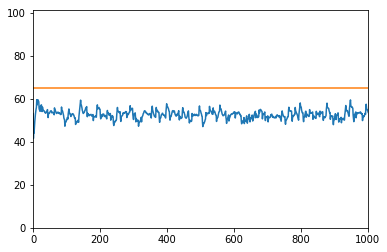

In [14]:
# 创建环境
env = MinorityGame_1(65)
# 创建玩家
agent_101 = [QLearningAgent(env,gamma=0.9,learning_rate=0.9,epsilon=0.1) for _ in range(101)]
# 博弈
rewards_2d, actions_2d = play_qlearning(env,agent_101,3000)
print("玩家总收益")
# 玩家总收益（仅绘制前1000轮）
plt.clf()
plt.plot(moving_average([sum(reward) for reward in rewards_2d],1))
plt.ylim(0,101)
plt.xlim(0,1000)
plt.pause(0.1)
print("选择1的人数")
# 选择1的人数（仅绘制前1000轮）
plt.clf()
plt.plot([sum(action) for action in actions_2d])
plt.ylim(0,101)
plt.xlim(0,1000)
plt.pause(0.1)
print("玩家总收益10轮移动平均")
# 玩家总收益10轮移动平均（仅绘制前1000轮）
plt.clf()
plt.plot(moving_average([sum(reward) for reward in rewards_2d],10))
plt.plot([65]*3000)
plt.ylim(0,101)
plt.xlim(0,1000)
plt.pause(0.1)

玩家总收益


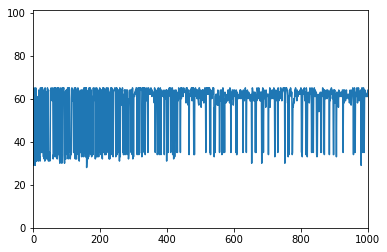

选择1的人数


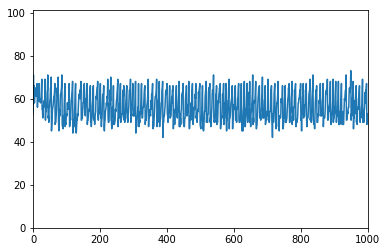

玩家总收益10轮移动平均


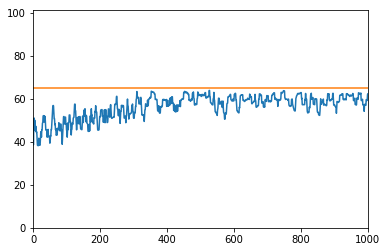

In [32]:
# 创建环境
env = MinorityGame_1(65)
# 创建玩家
agent_101 = [QLearningAgent(env,gamma=0.9,learning_rate=0.1,epsilon=0.1) for _ in range(101)]
# 博弈
rewards_2z, actions_2z = play_qlearning(env,agent_101,3000)
print("玩家总收益")
# 玩家总收益（仅绘制前1000轮）
plt.clf()
plt.plot(moving_average([sum(reward) for reward in rewards_2z],1))
plt.ylim(0,101)
plt.xlim(0,1000)
plt.pause(0.1)
print("选择1的人数")
# 选择1的人数（仅绘制前1000轮）
plt.clf()
plt.plot([sum(action) for action in actions_2d])
plt.ylim(0,101)
plt.xlim(0,1000)
plt.pause(0.1)
print("玩家总收益10轮移动平均")
# 玩家总收益10轮移动平均（仅绘制前1000轮）
plt.clf()
plt.plot(moving_average([sum(reward) for reward in rewards_2z],10))
plt.plot([65]*3000)
plt.ylim(0,101)
plt.xlim(0,1000)
plt.pause(0.1)

不同learning_rate对平均收益的影响


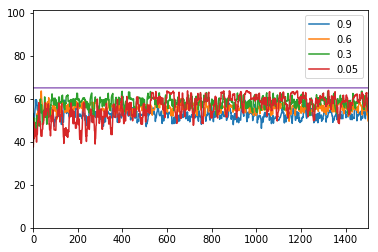

In [15]:
# 玩家总收益10轮移动平均，不同gamma对比
print("不同learning_rate对平均收益的影响")
plt.clf()
plt.plot(moving_average([sum(reward) for reward in rewards_2d],10),label ='0.9')
plt.plot(moving_average([sum(reward) for reward in rewards_2c],10),label ='0.6')
plt.plot(moving_average([sum(reward) for reward in rewards_2b],10),label ='0.3')
plt.plot(moving_average([sum(reward) for reward in rewards_2a],10),label ='0.05')
plt.plot([65]*3000)
plt.ylim(0,101)
plt.xlim(0,1500)
plt.legend()
plt.show()

不同learning_rate对玩家决策的影响


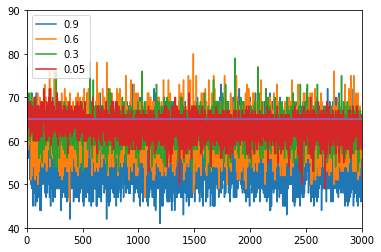

In [16]:
# 玩家决策，不同gamma对比
print("不同learning_rate对玩家决策的影响")
plt.clf()
plt.plot(moving_average([sum(reward) for reward in actions_2d],1),label ='0.9')
plt.plot(moving_average([sum(reward) for reward in actions_2c],1),label ='0.6')
plt.plot(moving_average([sum(reward) for reward in actions_2b],1),label ='0.3')
plt.plot(moving_average([sum(reward) for reward in actions_2a],1),label ='0.05')
plt.plot([65]*3000)
plt.ylim(40,90)
plt.xlim(0,3000)
plt.legend()
plt.show()

learning_rate0.05，折扣因子对玩家决策的影响


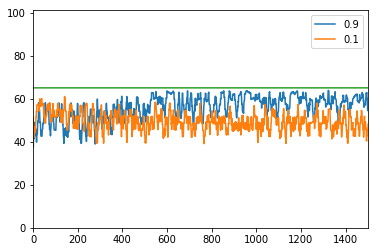

learning_rate0.1，折扣因子对玩家决策的影响


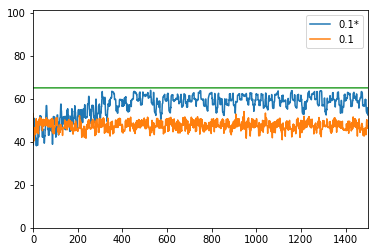

learning_rate0.3，折扣因子对玩家决策的影响


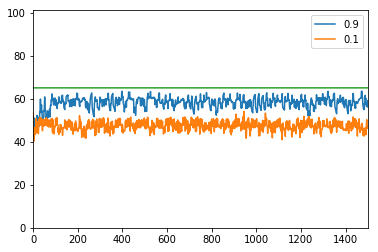

learning_rate0.6，折扣因子对玩家决策的影响


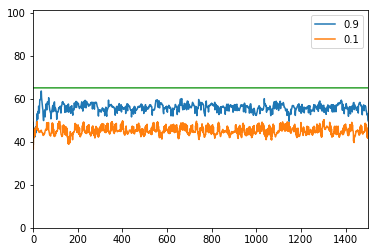

learning_rate0.9，折扣因子对玩家决策的影响


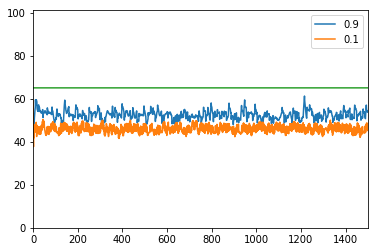

In [54]:
# 不同学习率情况下的折扣因子对收益的影响对比
print("learning_rate0.05，折扣因子对玩家决策的影响")
plt.plot(moving_average([sum(reward) for reward in rewards_2a],10),label ='0.9')
plt.plot(moving_average([sum(reward) for reward in rewards_1a],10),label ='0.1')
plt.plot([65]*3000)
plt.ylim(0,101)
plt.xlim(0,1500)
plt.legend()
plt.show()
print("learning_rate0.1，折扣因子对玩家决策的影响")
plt.plot(moving_average([sum(reward) for reward in rewards_2z],10),label ='0.1*')
plt.plot(moving_average([sum(reward) for reward in rewards_1b],10),label ='0.1')
plt.plot([65]*3000)
plt.ylim(0,101)
plt.xlim(0,1500)
plt.legend()
plt.show()
print("learning_rate0.3，折扣因子对玩家决策的影响")
plt.plot(moving_average([sum(reward) for reward in rewards_2b],10),label ='0.9')
plt.plot(moving_average([sum(reward) for reward in rewards_1b],10),label ='0.1')
plt.plot([65]*3000)
plt.ylim(0,101)
plt.xlim(0,1500)
plt.legend()
plt.show()
print("learning_rate0.6，折扣因子对玩家决策的影响")
plt.plot(moving_average([sum(reward) for reward in rewards_2c],10),label ='0.9')
plt.plot(moving_average([sum(reward) for reward in rewards_1c],10),label ='0.1')
plt.plot([65]*3000)
plt.ylim(0,101)
plt.xlim(0,1500)
plt.legend()
plt.show()
print("learning_rate0.9，折扣因子对玩家决策的影响")
plt.plot(moving_average([sum(reward) for reward in rewards_2d],10),label ='0.9')
plt.plot(moving_average([sum(reward) for reward in rewards_1d],10),label ='0.1')
plt.plot([65]*3000)
plt.ylim(0,101)
plt.xlim(0,1500)
plt.legend()
plt.show()


In [58]:
print("平均收益对比")
print("  0.05",sum(sum(r) for r in rewards_2a[100:500])/len(rewards_2a[100:500]))
print("   0.1",sum(sum(r) for r in rewards_2z[100:500])/len(rewards_0[100:500]))
print("   0.3",sum(sum(r) for r in rewards_2b[100:500])/len(rewards_2b[100:500]))
print("   0.6",sum(sum(r) for r in rewards_2c[100:500])/len(rewards_2c[100:500]))
print("   0.9",sum(sum(r) for r in rewards_2d[100:500])/len(rewards_2d[100:500]))

平均收益对比
  0.05 51.3425
   0.1 55.24
   0.3 58.555
   0.6 55.9975
   0.9 52.6275


In [59]:
print("平均收益对比")
print("  0.05",sum(sum(r) for r in rewards_2a[2100:2500])/len(rewards_2a[100:500]))
print("   0.1",sum(sum(r) for r in rewards_2z[2100:2500])/len(rewards_0[100:500]))
print("   0.3",sum(sum(r) for r in rewards_2b[2100:2500])/len(rewards_2b[100:500]))
print("   0.6",sum(sum(r) for r in rewards_2c[2100:2500])/len(rewards_2c[100:500]))
print("   0.9",sum(sum(r) for r in rewards_2d[2100:2500])/len(rewards_2d[100:500]))

平均收益对比
  0.05 59.385
   0.1 59.32
   0.3 58.2775
   0.6 56.2775
   0.9 52.38


In [53]:
print("平均收益对比")
print("  0.05",sum(sum(r) for r in rewards_2a[2400:2500])/len(rewards_2a[400:500]))
print("   0.1",sum(sum(r) for r in rewards_2z[2400:2500])/len(rewards_0[400:500]))
print("   0.3",sum(sum(r) for r in rewards_2b[2400:2500])/len(rewards_2b[400:500]))
# print("   0.6",sum(sum(r) for r in rewards_2c[2400:2500])/len(rewards_2c[400:500]))
print("   0.9",sum(sum(r) for r in rewards_2d[2400:2500])/len(rewards_2d[400:500]))

平均收益对比
  0.05 57.61
   0.1 59.12
   0.3 57.62
   0.9 51.76


不同gamma对玩家决策的影响


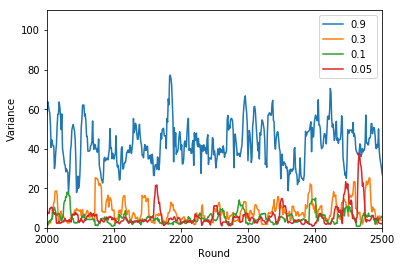

In [60]:
# 玩家决策，不同gamma对比
print("不同gamma对玩家决策的影响")
plt.clf()
plt.xlabel("Round")
plt.ylabel("Variance")
plt.plot(variance([sum(reward) for reward in actions_2d],10),label ='0.9')
# plt.plot(variance([sum(reward) for reward in actions_1c],10),label ='0.6')
plt.plot(variance([sum(reward) for reward in actions_2b],10),label ='0.3')
plt.plot(variance([sum(reward) for reward in actions_2z],10),label ='0.1')
plt.plot(variance([sum(reward) for reward in actions_2a],10),label ='0.05')
plt.xlim(2000,2500)
plt.ylim(0,110)
# plt.axvline(51)
plt.legend()
plt.show()

不同gamma对平均收益的影响


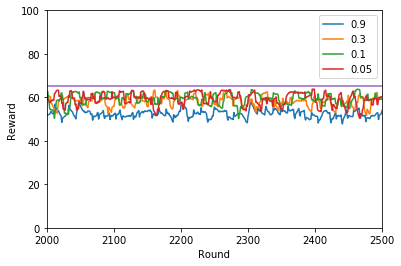

In [52]:
# 玩家总收益10轮移动平均，不同gamma对比
print("不同gamma对平均收益的影响")
plt.clf()
plt.xlabel("Round")
plt.ylabel("Reward")
plt.plot(moving_average([sum(reward) for reward in rewards_2d],10),label ='0.9')
# plt.plot(moving_average([sum(reward) for reward in rewards_1c],10),label ='0.6')
plt.plot(moving_average([sum(reward) for reward in rewards_2b],10),label ='0.3')
plt.plot(moving_average([sum(reward) for reward in rewards_2z],10),label ='0.1')
plt.plot(moving_average([sum(reward) for reward in rewards_2a],10),label ='0.05')
plt.plot([65]*3000)
plt.ylim(0,100)
plt.xlim(2000,2500)
plt.legend()
plt.show()

不同gamma对平均收益的影响


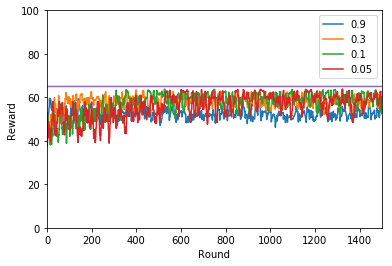

In [55]:
# 玩家总收益10轮移动平均，不同gamma对比
print("不同gamma对平均收益的影响")
plt.clf()
plt.xlabel("Round")
plt.ylabel("Reward")
plt.plot(moving_average([sum(reward) for reward in rewards_2d],10),label ='0.9')
# plt.plot(moving_average([sum(reward) for reward in rewards_1c],10),label ='0.6')
plt.plot(moving_average([sum(reward) for reward in rewards_2b],10),label ='0.3')
plt.plot(moving_average([sum(reward) for reward in rewards_2z],10),label ='0.1')
plt.plot(moving_average([sum(reward) for reward in rewards_2a],10),label ='0.05')
plt.plot([65]*3000)
plt.ylim(0,100)
plt.xlim(0,1500)
plt.legend()
plt.show()

In [63]:
print("决策方差对比")
print("  0.9",np.var([sum(r) for r in actions_2d[2000:2500]]))
print("  0.6",np.var([sum(r) for r in actions_2c[2000:2500]]))
print("  0.3",np.var([sum(r) for r in actions_2b[2000:2500]]))
print("  0.1",np.var([sum(r) for r in actions_2z[2000:2500]]))
print(" 0.05",np.var([sum(r) for r in actions_2a[2000:2500]]))

决策方差对比
  0.9 44.621644
  0.6 17.077196
  0.3 9.981323999999999
  0.1 5.383083999999999
 0.05 6.7355


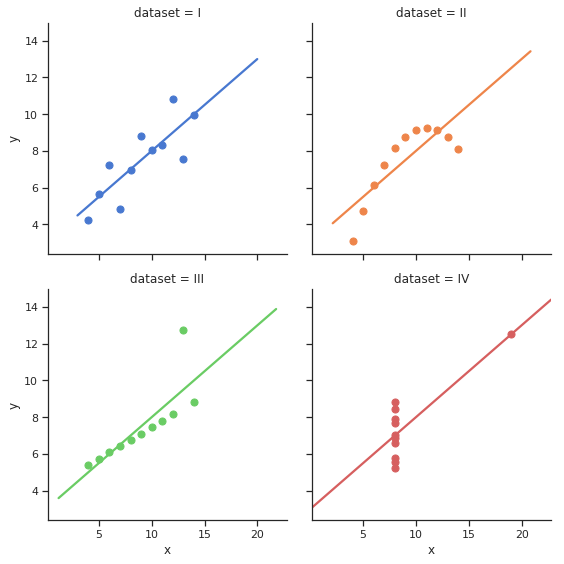

In [64]:
import seaborn as sns
sns.set(style="ticks")

# Load the example dataset for Anscombe's quartet
df = sns.load_dataset("anscombe")

# Show the results of a linear regression within each dataset
sns.lmplot(x="x", y="y", col="dataset", hue="dataset", data=df,
           col_wrap=2, ci=None, palette="muted", height=4,
           scatter_kws={"s": 50, "alpha": 1});

AttributeError: module 'matplotlib.pyplot' has no attribute 'xlabel'